# AutoML Classification with Azure ML

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

This is a copy of the test set of the **UCI ML hand-written digits datasets** http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where each class refers to a digit.



<img src="https://www.seewald.at/img/L/digits.gif">


## Documentation Azure ML service
> https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-automated-ml

## 1. Informations

As part of the setup you have already created an Azure ML `Workspace` object. <br> For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [2]:
import datetime
now = datetime.datetime.now()
print(now)

2020-10-13 08:12:32.340270


In [3]:
import azureml.core
print("Version Azure ML :", azureml.core.VERSION)

Version Azure ML : 1.15.0


In [4]:
import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

## 2. Connexion workspace Azure ML service

In [5]:
ws = Workspace.from_config()

experiment_name = 'workshop-automlclassification'

project_folder = './sample_projects/workshopautoml'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

SDK version        1.15.0                          
Workspace Name     workshoplcl                     
Resource Group     workshoplcl-rg                  
Location           westeurope                      
Project Directory  ./sample_projects/workshopautoml
Experiment Name    workshop-automlclassification

## 3. Chargement des données

This uses scikit-learn's [load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) method.

Each datapoint is a 8x8 image of a digit.

In [6]:
from sklearn import datasets

digits = datasets.load_digits()

# Exclude the first 100 rows from training so that they can be used for test.
X_train = digits.data[100:,:]
y_train = digits.target[100:]

In [7]:
print("Taille du dataset : ", digits.data.shape)

Taille du dataset :  (1797, 64)


> On a 1797 images de 8 sur 8 pixels (=64).

### Exemples d'images :

In [8]:
def visu(chiffre):
    import matplotlib.pyplot as plt 
    plt.gray() 
    plt.matshow(digits.images[chiffre]) 
    plt.show() 

<Figure size 432x288 with 0 Axes>

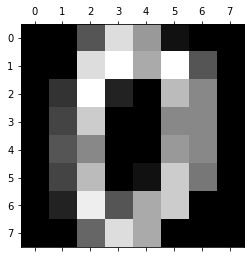

In [9]:
visu(0)

<Figure size 432x288 with 0 Axes>

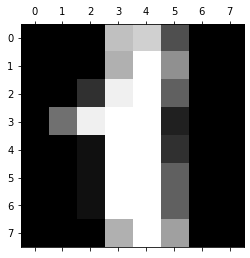

In [10]:
visu(1)

<Figure size 432x288 with 0 Axes>

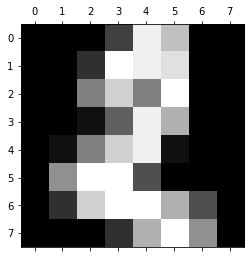

In [11]:
visu(2)

<Figure size 432x288 with 0 Axes>

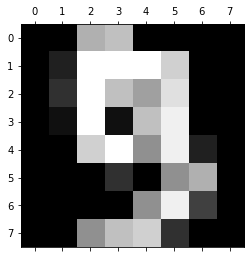

In [12]:
visu(9)

## 4. Configuration AutoML



In [13]:
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automlclassif.log',
                             primary_metric = 'AUC_weighted', #the metric I want to use
                             iteration_timeout_minutes = 2, # Temps max par itération
                             experiment_timeout_minutes = 15, # Temps max pour le process AutoML
                             enable_early_stopping=True, # Sortie si pas d'amélioration de la métrique
                             iterations = 5,           # Possibilité de définir le nombre d'itérations max
                             n_cross_validations = 3,    # Nombre de validations croisées
                             verbosity = logging.INFO,
                             X = X_train, 
                             y = y_train)

WARNING - The AutoMLConfig parameters, X and y, will soon be deprecated. Please refer to our documentation for the latest interface: https://aka.ms/AutoMLConfig


## 5. AutoML

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

`AUC_weighted` is the **metric** used.

In [14]:
#Mise à jour si besoin (redémarrer le kernel ensuite)
#!pip install --upgrade azureml-sdk[automl]
#!pip install --upgrade azureml-sdk[explain,contrib]
#!pip install interpret-community==0.15

In [15]:
#!pip install numpy==1.18

In [16]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_922d79a3-8b5b-44d5-8e08-b0228335b1e9

Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing f

In [17]:
local_run

Run(Experiment: workshop-automlclassification,
Id: AutoML_922d79a3-8b5b-44d5-8e08-b0228335b1e9,
Type: automl,
Status: Completed)

## 6. Exploration des résultats AutoML

### 6.1 Notebook Widget


In [18]:
from azureml.widgets import RunDetails
RunDetails(local_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…


### 6.2 Métriques par itération


In [19]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

0    1    2    3    4
average_precision_score_micro    0.99 0.99 1.00 1.00 1.00
average_precision_score_weighted 0.99 0.99 1.00 1.00 1.00
f1_score_micro                   0.96 0.96 0.98 0.98 0.98
average_precision_score_macro    0.99 0.99 1.00 1.00 1.00
norm_macro_recall                0.96 0.96 0.97 0.98 0.98
precision_score_micro            0.96 0.96 0.98 0.98 0.98
precision_score_weighted         0.96 0.96 0.98 0.98 0.98
matthews_correlation             0.96 0.96 0.97 0.98 0.98
balanced_accuracy                0.96 0.96 0.98 0.98 0.98
log_loss                         0.11 0.13 0.13 0.08 0.48
AUC_weighted                     1.00 1.00 1.00 1.00 1.00
precision_score_macro            0.96 0.96 0.98 0.98 0.98
accuracy                         0.96 0.96 0.98 0.98 0.98
f1_score_macro                   0.96 0.96 0.98 0.98 0.98
AUC_micro                        1.00 1.00 1.00 1.00 1.00
AUC_macro                        1.00 1.00 1.00 1.00 1.00
f1_score_weighted                0.96 0.96 0.98 0.98 0.98
recall_score_weighted            0.96 0.96 0.98 0.98 0.98
recall_score_macro               0.96 0.96 0.98 0.98 0.98
recall_score_micro               0.96 0.96 0.98 0.98 0.98
weighted_accuracy                0.96 0.96 0.98 0.98 0.98

## 7. Récupération du meilleur modèle

In [20]:
best_run, fitted_model = local_run.get_output()
print("Best run =", best_run)

Best run = Run(Experiment: workshop-automlclassification,
Id: AutoML_922d79a3-8b5b-44d5-8e08-b0228335b1e9_3,
Type: None,
Status: Completed)


In [21]:
print(fitted_model)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                     steps=[('sparsenormalizer',
                                                                             <azureml.automl.runtime.shared.model_wrappers.SparseNormalizer object at 0x7f2f60257dd8>),
                                                                            ('kneighborsclassifier',
                          

In [22]:
fitted_model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                     steps=[('sparsenormalizer',
                                                                             <azureml.automl.runtime.shared.model_wrappers.SparseNormalizer object at 0x7f2f60257dd8>),
                                                                            ('kneighborscl

In [23]:
fitted_model.steps

[('datatransformer',
  DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                  feature_sweeping_config=None, feature_sweeping_timeout=None,
                  featurization_config=None, force_text_dnn=None,
                  is_cross_validation=None, is_onnx_compatible=None, logger=None,
                  observer=None, task=None, working_dir=None)),
 ('prefittedsoftvotingclassifier',
  PreFittedSoftVotingClassifier(classification_labels=None,
                                estimators=[('0',
                                             Pipeline(memory=None,
                                                      steps=[('maxabsscaler',
                                                              MaxAbsScaler(copy=True)),
                                                             ('lightgbmclassifier',
                                                              LightGBMClassifier(boosting_type='gbdt',
                                                                                 class_weight=None,
                                                                                 colsample_bytree=1.0,
                                                                                 importance_type='split',
                                                                                 learning_rate=0.1,
                                                                                 max_depth=-1,
                                                                                 min_child_samples=20,
                                                                                 min_child_weight=0.001,
                                                                                 min_spl...
                                             Pipeline(memory=None,
                                                      steps=[('sparsenormalizer',
                                                              <azureml.automl.runtime.shared.model_wrappers.SparseNormalizer object at 0x7f2f60257dd8>),
                                                             ('kneighborsclassifier',
                                                              KNeighborsClassifier(algorithm='auto',
                                                                                   leaf_size=30,
                                                                                   metric='l1',
                                                                                   metric_params=None,
                                                                                   n_jobs=1,
                                                                                   n_neighbors=9,
                                                                                   p=2,
                                                                                   weights='distance'))],
                                                      verbose=False))],
                                flatten_transform=None,
                                weights=[0.25, 0.25, 0.5]))]

In [24]:
print("Métriques du meilleur modèle :")
print()
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print('-', metric_name, '=', metric)

Métriques du meilleur modèle :

- average_precision_score_micro = 0.9981958210368163
- average_precision_score_weighted = 0.9982861908162683
- f1_score_micro = 0.9811449180191167
- average_precision_score_macro = 0.9982950848679244
- norm_macro_recall = 0.9793228481814854
- precision_score_micro = 0.9811449180191167
- precision_score_weighted = 0.9816871937104551
- matthews_correlation = 0.9790749564443627
- balanced_accuracy = 0.981390563363337
- log_loss = 0.08312438462207805
- AUC_weighted = 0.9997751117334203
- precision_score_macro = 0.982034249301579
- accuracy = 0.9811449180191167
- f1_score_macro = 0.9814739356943813
- AUC_micro = 0.9997862283731402
- AUC_macro = 0.9997773323566553
- f1_score_weighted = 0.981179416793549
- recall_score_weighted = 0.9811449180191167
- recall_score_macro = 0.981390563363337
- recall_score_micro = 0.9811449180191167
- weighted_accuracy = 0.9808555409309861
- accuracy_table = aml://artifactId/ExperimentRun/dcid.AutoML_922d79a3-8b5b-44d5-8e08-b02283

### 7.1 Changement de la métrique AutoML


In [25]:
lookup_metric = "f1_score_weighted"
best_run, fitted_model = local_run.get_output(metric = lookup_metric)
print("Meilleur modèle :")
print()
print('Best Run =', best_run)
print()
print(fitted_model)

Meilleur modèle :

Best Run = Run(Experiment: workshop-automlclassification,
Id: AutoML_922d79a3-8b5b-44d5-8e08-b0228335b1e9_3,
Type: None,
Status: Completed)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                     steps=[('sparsenormalizer',
                                                                             <azureml.automl.runtime.shared.model_wrappers.SparseNormal

Choix d'une itération particulière :

In [26]:
iteration = 3

my_run, my_model = local_run.get_output(iteration = iteration)
print("Modèle",iteration,"ème itération :")
print(my_run)
print()
print(my_model)

Modèle 3 ème itération :
Run(Experiment: workshop-automlclassification,
Id: AutoML_922d79a3-8b5b-44d5-8e08-b0228335b1e9_3,
Type: None,
Status: Completed)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                     steps=[('sparsenormalizer',
                                                                             <azureml.automl.runtime.shared.model_wrappers.SparseNormalizer 

## 8. Application du modèle

### 8.1 Chargement des données

In [27]:
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

### 8.2 Test
We will try to predict 2 digits and see how our model works.

4


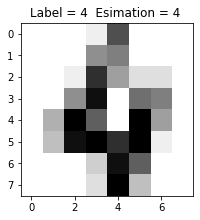

0


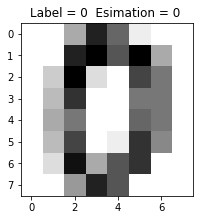

In [28]:
# Randomly select digits and test.
for index in np.random.choice(len(y_test), 2, replace = False):
    print(index)
    predicted = fitted_model.predict(X_test[index:index + 1])[0]
    label = y_test[index]
    title = "Label = %d  Esimation = %d " % (label, predicted)
    fig = plt.figure(1, figsize = (3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    plt.show()

## 9. Référencement du modèle

### Meilleur modèle

In [29]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print()
print(fitted_model)
print()
print("Métriques :")
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, '=', metric)

Run(Experiment: workshop-automlclassification,
Id: AutoML_922d79a3-8b5b-44d5-8e08-b0228335b1e9_3,
Type: None,
Status: Completed)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                     steps=[('sparsenormalizer',
                                                                             <azureml.automl.runtime.shared.model_wrappers.SparseNormalizer object at 0x7f2f6125a048>

In [30]:
for step in fitted_model.named_steps:
    print(step)

datatransformer
prefittedsoftvotingclassifier


### Référencement du modèle

In [31]:
from azureml.core import Model

best_run.register_model(model_path='outputs/model.pkl', model_name='mybestmodel',
                        tags={'Training context':'Azure Auto ML'},
                        properties={'AUC': best_run_metrics['AUC_weighted'], 'Accuracy': best_run_metrics['accuracy']})

Model(workspace=Workspace.create(name='workshoplcl', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='workshoplcl-rg'), name=mybestmodel, id=mybestmodel:1, version=1, tags={'Training context': 'Azure Auto ML'}, properties={'AUC': '0.9997751117334203', 'Accuracy': '0.9811449180191167'})

In [32]:
# Liste des modèles référencés
for model in Model.list(ws):
    print(model.name, '- version =', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

mybestmodel - version = 1
	 Training context : Azure Auto ML
	 AUC : 0.9997751117334203
	 Accuracy : 0.9811449180191167


DiabetesRidge - version = 2
	 area : Diabetes
	 type : Regression Ridge
	 k : 0.2
	 MSE : 3026.667734128127
	 R2 : 0.4067092393506434
	 RMSE : 55.015159130262695
	 Framework : Azure ML SDK


DiabetesRidge - version = 1
	 area : Diabetes
	 type : Regression Ridge
	 k : 0.2
	 MSE : 3026.667734128127
	 R2 : 0.4067092393506434
	 RMSE : 55.015159130262695
	 Framework : Azure ML SDK


monmodele - version = 1
	 type : classification
	 framework : scikit
	 description : madescription
	 run_id : monexperimentation_1602575538_84ebca82




<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">